Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Загружаем и смотрим наши данные

In [55]:
train = pd.read_csv("/home/../train.csv")
test = pd.read_csv("/home/../test.csv")

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


Видим какую то дичь из колонок с лейблами вида pixelN(всего таких 784 колонки), а также целевую переменную label, которую нам надо предсказать для теста. Смотрим в data на странице соревнования на каггле и допетриваем, что колонки это значения яркости пикселей в градации черно-белого, просто они развернуты в единый плоский вектор, а не по человечески 28х28 матрицу. Ну ок структура данных чуть прояснилась. Самое время посмотреть, а действительно ли там циферки нарисованы(может дикпики??).

Это цифра 6


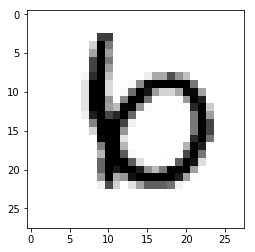

Это хз че за цифра, потому что это тест


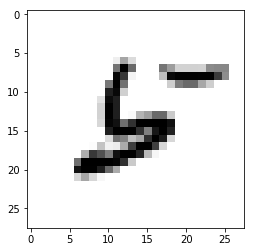

In [24]:
labels = train['label'].values
train_copy = train.drop(['label'], axis=1)
train_images = np.array(train_copy).reshape(42000,28,28)
test_images = np.array(test).reshape(28000,28,28)
rand_idx = np.random.randint(0, 28000)
digit = train_images[rand_idx]
print("Это цифра {}".format(labels[rand_idx]))
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

digit = test_images[rand_idx]
print("Это хз че за цифра, потому что это тест")
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

Сейчас расчехляем торч. Описываем модель Torch из 6 convolutional слоев, добавим нормализации по батчам(это нужно для нормализации весов внутри одного слоя, когда один нейрон вроде меняет веса, а другой умирает: с relu такое часто случается, это называется проблемой затухающего нейрона). Добавим дропаут(с вероятностью 0.3 и 0.5) после max_pooling, дропаут и пулинг нужны чтобы не оверфитнутся. Ну и в конце 2 fully connected слоя, с пипиркой в конце с 10 классами.

In [241]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5,5))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(5,5))
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2_drop = nn.Dropout2d(p = 0.3)
        self.conv3_drop = nn.Dropout2d(p = 0.5)
        self.fc1 = nn.Linear(128, 100)
        self.fc2 = nn.Linear(100, 10)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3))
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3,3))
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3,3))
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=(1,1))
        self.bn6 = nn.BatchNorm2d(128)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.conv2_drop(F.max_pool2d(self.bn2(x),2))
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = F.max_pool2d(x,2)
        x = self.conv3_drop(x)
        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = F.relu(self.conv6(x))
        x = self.bn6(x)
        size =  x.size()[1]*x.size()[2]*x.size()[3]
        x = x.view(-1, size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Теперь надо инициализировать саму модель, гиперпараметры, loss функцию, и опитимизатор.

In [242]:
model = MnistModel()

use_gpu = torch.cuda.is_available()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.3, momentum = 0.1)
if use_gpu:
    model = model.cuda()
num_train = 42000
num_epoch = 40000
num_batch = 210

Нам нужны функции для тренировки сети и предикта на тестовом датасете. Го писать

In [61]:
def train_net(num_epoch, num_train, num_batch, X_data, X_label, criterion, optimizer, model):
    idx = 0
    for epoch in range(num_epoch):
        if idx + num_batch >= num_train:
            idx = 0
        else:
            idx = idx + num_batch
        mini_batch  = Variable(X_data[idx:(idx+num_batch)].clone())
        mini_batch_label = Variable(X_label[idx:(idx+num_batch)].clone(), requires_grad = False)
        mini_batch = mini_batch.type(torch.FloatTensor)
        mini_batch_label = mini_batch_label.type(torch.LongTensor)
        if use_gpu:
            mini_batch = mini_batch.cuda()
            mini_batch_label = mini_batch_label.cuda()
        optimizer.zero_grad()
        out = model(mini_batch)
        mini_batch_label = mini_batch_label.view(num_batch)
        loss  = criterion(out, mini_batch_label)
        loss.backward()
        optimizer.step() 

        if (epoch + 1) % 4000 == 0:
            print("Epoch = %d, Loss = %f" %(epoch + 1, loss.data[0]))

def predict(model, num_test, num_sub, Y_data):
    model.eval()
    final_prediction = np.ndarray(shape = (num_test, 2), dtype=int)
    for sample in range(num_test):
        sample_data = Variable(Y_data[sample:sample+1].clone())
        sample_data = sample_data.type(torch.FloatTensor)
        if use_gpu:
            sample_data = sample_data.cuda()
        sample_out = model(sample_data)
        pred = torch.max(sample_out, 1)
        final_prediction[sample][0] = 1 + sample
        final_prediction[sample][1] = pred[1][0]
        if (sample + 1) % 4000 == 0:
            print("Total tested = %d" %(sample + 1))
    submission = pd.DataFrame(final_prediction, dtype=int, columns=['ImageId', 'Label'])
    submission.to_csv('submission_{}.csv'.format(num_sub), index=False, header=True)

Надо подготовить данные для того, чтобы скормить нашей сеточке (посолить, поперчить, нормализовать). Нормализуем, поделим все пиксели на 255, приведем их к интервалу [0, 1], это необходимо для быстрой сходимости градиентного спуска, так как в ненормализованных данных значения могут быть сильно разбросаны и коррекция весов нейронки будет идти дольше.

In [63]:
X = train[:, 1:].reshape(train.shape[0], 1, 28, 28)
Y = train[:,0]
X = X.astype(float)
X /= 255.0
X  = torch.from_numpy(X)
Y = Y.astype(int);
Y = torch.from_numpy(Y)
Y = Y.view(Y.shape[0],-1)
print (X.size(), Y.size())
X_test  = test.values.reshape(test.shape[0], 1, 28, 28)
X_test  = X_test.astype(float)
X_test /= 255.0
X_test  = torch.from_numpy(X_test)
print (X_test.size())

torch.Size([42000, 1, 28, 28]) torch.Size([42000, 1])
torch.Size([28000, 1, 28, 28])


In [68]:
train_net(num_epoch, num_train, num_batch, X, Y, criterion, optimizer, model)

/home/d.milovanov/sentiment_prediction/torch_venv/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch = 4000, Loss = 0.002068
Epoch = 8000, Loss = 0.001057
Epoch = 12000, Loss = 0.000275
Epoch = 16000, Loss = 0.000090
Epoch = 20000, Loss = 0.000095
Epoch = 24000, Loss = 0.000187
Epoch = 28000, Loss = 0.000052
Epoch = 32000, Loss = 0.000052
Epoch = 36000, Loss = 0.000059
Epoch = 40000, Loss = 0.000160


Сделаем предикт и самбит нашей первой вариации сетки.

In [70]:
predict(model, test.shape[0], 1, X_test)

Total tested = 4000
Total tested = 8000
Total tested = 12000
Total tested = 16000
Total tested = 20000
Total tested = 24000
Total tested = 28000


Скор 0.99414 не радует, давайте попробуем агеменитруем наши данные. Ведь чем больше данных мы скормим нашей сеточке, тем она будет устойчивей при обучении, не будет оверфитится и будем надеется покажет лучший скор на LB. Сейчас мы децл агументируем наши циферки, добавим для каждого изображения поворот на 20 градусов, а также сдвиг по каждой из осей. Таким образом размер датасета увеличится в 3 раза. Посмотрим на размерность получившихся векторов. Такой же херней надо пострадать с метками для циферок.

In [179]:
from scipy.ndimage import rotate
from scipy.ndimage import shift

def img_shift(a):
    return shift(a, .5)
    
def img_rotate(a):
    return rotate(a, 20, reshape=False)

X = train[:, 1:].reshape(train.shape[0], 28, 28)
X_rotated = np.zeros((train.shape[0], 28, 28))
X_shift = np.zeros((train.shape[0], 28, 28))
for array in range(X.shape[0]):
    X_shift[array] = img_shift(X[array])
    X_rotated[array] = img_rotate(X[array])

print(X_shift.shape, X_rotated.shape)

(42000, 28, 28) (42000, 28, 28)


In [210]:
X_augmented = np.concatenate((X, X_shift, X_rotated))
Y_augmented = np.concatenate((Y, Y, Y))
print(X_augmented.shape, Y_augmented.shape)

(126000, 28, 28) (126000, 1)


Подготавливаем данные для обучения

In [218]:
X_augmented = X_augmented.reshape(train.shape[0]*3, 1, 28, 28)
X_augmented = X_augmented.astype(float)
X_augmented /= 255.0
X_augmented = torch.from_numpy(X_augmented)
Y_augmented = Y_augmented.astype(int);
Y_augmented = torch.from_numpy(Y_augmented);
Y_augmented = Y_augmented.view(Y_augmented.shape[0],-1)
print (X_augmented.size(), Y_augmented.size())

torch.Size([126000, 1, 28, 28]) torch.Size([126000, 1])


In [219]:
num_train=126000
train_net(num_epoch, num_train, num_batch, X_augmented, Y_augmented, criterion, optimizer, model)

/home/d.milovanov/sentiment_prediction/torch_venv/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch = 4000, Loss = 0.027163
Epoch = 8000, Loss = 0.004682
Epoch = 12000, Loss = 0.000707
Epoch = 16000, Loss = 0.000390
Epoch = 20000, Loss = 0.000140
Epoch = 24000, Loss = 0.000205
Epoch = 28000, Loss = 0.000069
Epoch = 32000, Loss = 0.000007
Epoch = 36000, Loss = 0.000144
Epoch = 40000, Loss = 0.000217


Сделаем предикт и самбит нашей сетки c аугментацией. И посмотрим увеличился ли скор

In [221]:
predict(model, test.shape[0], 2, X_test)

Total tested = 4000
Total tested = 8000
Total tested = 12000
Total tested = 16000
Total tested = 20000
Total tested = 24000
Total tested = 28000


Скор на LB 0.99271, получается наша аугментация внесла какой то мусор на вход. ОК, мы не будем сдаваться.

А теперь сделаем финт ушами и добавим в наши данные исходный датасет MNIST и будем обучаться на аггрегированном датасете с 70К + наши 42К трейна

In [ ]:
!wget https://s3.amazonaws.com/img-datasets/mnist.npz

In [231]:
train_out = np.load('/home/../../mnist.npz')
d = dict(zip(("data1{}".format(k) for k in train_out), (train_out[k] for k in train_out)))
x_train = np.concatenate((d['data1x_train'], d['data1x_test']))
y_train = np.concatenate((d['data1y_train'], d['data1y_test']))
x_train = x_train.reshape(x_train.shape[0], 1, 28, 28)
print(x_train.shape, y_train.shape)
X = train[:, 1:].reshape(train.shape[0], 1, 28, 28)
Y = train[:,0]
X = np.concatenate((x_train, X))
X = X.astype(float)
X /= 255.0
X  = torch.from_numpy(X)
Y = np.concatenate((y_train, Y))
Y = Y.astype(int)
Y = torch.from_numpy(Y)
Y = Y.view(Y.shape[0],-1)
print (X.size(), Y.size())

(70000, 1, 28, 28) (70000,)
torch.Size([112000, 1, 28, 28]) torch.Size([112000, 1])


In [244]:
num_train=112000
num_batch = 1120
train_net(num_epoch, num_train, num_batch, X, Y, criterion, optimizer, model)

/home/d.milovanov/sentiment_prediction/torch_venv/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch = 4000, Loss = 0.000306
Epoch = 8000, Loss = 0.000061
Epoch = 12000, Loss = 0.001545
Epoch = 16000, Loss = 0.000213
Epoch = 20000, Loss = 0.000111
Epoch = 24000, Loss = 0.000050
Epoch = 28000, Loss = 0.000133
Epoch = 32000, Loss = 0.000205
Epoch = 36000, Loss = 0.000049
Epoch = 40000, Loss = 0.000023


In [240]:
predict(model, test.shape[0], 3, X_test)

Total tested = 4000
Total tested = 8000
Total tested = 12000
Total tested = 16000
Total tested = 20000
Total tested = 24000
Total tested = 28000


Оп и мы получили 28 место на LB со скором 1.0, понятно что это нечестно, ведь мы по сути в обучающую выборку запихнули данные из теста, но зато получили общее представление о слоях convolutional neural network, немного поигрались с данными, для hello world знаний достаточно.